# Notebook for Visualizing and Analyzing Simulated Trajectories

Written by L.F. Heald

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gued_theory as gt
import gued
import scipy.optimize
import scipy.special
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import pandas as pd

angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/' # The molecular .xyz/.csv paths



## Load Data

In [30]:
import h5py
import re
from collections import defaultdict
import numpy as np

inv_angs = '($\mathrm{\AA}^{-1}$)'
angs = '($\mathrm\{\AA})'

def load_trajectory_h5(file_name, group_name):
    """
    Reads an HDF5 file and groups datasets by their numeric run ID (e.g., '0014').
    
    ARGUMENTS:
    
    file_name (str):
        Name and path to the HDF5 file to read from.
    group_name (str):
        The name of the group to search in the HDF5 file.
    
    RETURNS:
    
    A dictionary where the keys are run IDs (e.g., '0014') and the values 
    are dictionaries with dataset names as keys and the dataset values as NumPy arrays.
    """
    run_dict = defaultdict(dict)  # Dictionary to group datasets by run ID
    
    # Open the HDF5 file
    with h5py.File(file_name, 'r') as f:
        if group_name not in f:
            print(f"Group '{group_name}' not found in the file.")
            return run_dict
        
        group = f[group_name]
        
        # Regex pattern to extract the numeric run ID (e.g., '0014')
        pattern = re.compile(r'run_(\d{4})')
        
        # Loop through the datasets in the group
        for dataset_name in group.keys():
            match = pattern.search(dataset_name)
            if match:
                run_id = match.group(1)  # Extract the numeric run ID (e.g., '0014')
                variable_name = dataset_name.split(f'_run_{run_id}')[0]  # Extract the variable name
                
                dataset = group[dataset_name]
                
                # Check if the dataset is scalar
                if dataset.shape == ():  # Scalar dataset
                    run_dict[run_id][variable_name] = dataset[()]  # Access scalar data
                else:  # Non-scalar dataset (array-like)
                    run_dict[run_id][variable_name] = dataset[:]  # Access array data
            else:
                print(f"Warning: Could not extract run ID from '{dataset_name}'")
    
    return dict(run_dict)  # Convert defaultdict to regular dict


# notes_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\"
# notes_name = "NB_CI_crossing_T0_time.txt"

def read_notes(file_path):
    with open(file_path, 'r') as file:
        text = file.readlines()
    
    traj_id = []
    idx = []
    ci_time = []
    t0 = []
    groups = []
    for line in text[1:]:  # Assuming you want to skip the first line
        string = list(map(str, line.split()))
        
        if len(string) < 4:
            continue
        temp = list(map(str, string[0].split('/')))
        traj_id.append(temp[1][5:-1])
        
        if temp[0].lower() == 'singlet_2':
            groups.append('s2')
        elif temp[0].lower() == 'singlet_3':
            groups.append('s3')
        elif temp[0].lower() == 'singlet_4':
            groups.append('s4')
        else:
            continue
        # Convert idx (string[2]) to int or np.nan if 'none'
        if string[2].lower() == 'none':
            idx.append(np.nan)
        else:
            idx.append(int(string[2]))
        
        # Convert ci_time (string[4]) to float or np.nan if 'none'
        if string[4].lower() == 'none':
            ci_time.append(np.nan)
        else:
            ci_time.append(float(string[4]))
        
        # You can extend this for other columns if needed
        # Example for t0 (string[3])
        if string[3].lower() == 'none':
            t0.append(np.nan)
        else:
            t0.append(float(string[3]))

    return groups, traj_id, idx, ci_time, t0

# Example usage:
# traj_id, idx, ci_time, t0 = read_notes('your_file.txt')


# notes_name = notes_path + notes_name
# groups, traj_keys, idx, ci_time, t0_val = read_notes(notes_name)
# h5_file = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\NB_Trajectories_2024-09-05.h5"

# for i, group in enumerate(groups):
#     run_number = traj_keys[i]
#     dictionary = {'CI_time':ci_time[i], 't0':t0_val[i], 'idx':idx[i]}
#     gued.add_to_h5(h5_file, group, dictionary, run_number=run_number)
#     time.sleep(1)

Easier to keep things as a dictionary... 

In [31]:
file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "QC_Trajectories_2024-09-05.h5"
print(file_name)
#gt.inspect_h5(file_name)

QC_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s2"))
new_row = pd.DataFrame([["s2"] * len(QC_s2_traj.columns)], columns=QC_s2_traj.columns, index=["init_state"])
QC_s2_df = pd.concat([QC_s2_traj, new_row])

QC_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s3"))
new_row = pd.DataFrame([["s3"] * len(QC_s3_traj.columns)], columns=QC_s3_traj.columns, index=["init_state"])
QC_s3_df = pd.concat([QC_s3_traj, new_row])

QC_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s4"))
new_row = pd.DataFrame([["s4"] * len(QC_s4_traj.columns)], columns=QC_s4_traj.columns, index=["init_state"])
QC_s4_df = pd.concat([QC_s4_traj, new_row])

QC_df = pd.concat([QC_s2_df, QC_s3_df, QC_s4_df], axis=1)

file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "NB_Trajectories_2024-09-05.h5"
#print(f"{len(s2_trajectories)} trajectories in this group")

NB_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "s2"))
new_row = pd.DataFrame([["s2"] * len(NB_s2_traj.columns)], columns=NB_s2_traj.columns, index=["init_state"])
NB_s2_df = pd.concat([NB_s2_traj, new_row])

NB_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "s3"))
new_row = pd.DataFrame([["s3"] * len(NB_s3_traj.columns)], columns=NB_s3_traj.columns, index=["init_state"])
NB_s3_df = pd.concat([NB_s3_traj, new_row])

NB_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "s4"))
new_row = pd.DataFrame([["s4"] * len(NB_s4_traj.columns)], columns=NB_s4_traj.columns, index=["init_state"])
NB_s4_df = pd.concat([NB_s4_traj, new_row])

NB_df = pd.concat([NB_s2_df, NB_s3_df, NB_s4_df], axis=1)


C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\QC data and code\Theory Structures\QC_Trajectories_2024-09-05.h5


### Importing Experimental Data

In [32]:
folder_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\"

variable = "delay_all_cut"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
time_exp = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {time_exp.shape}")

variable = "dI_I_all_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
simu_all = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {simu_all.shape}")

variable = "dI_I_all_simu_slow"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
simu_slow = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {simu_slow.shape}")

# variable = "A_smooth"
# mat_file = folder_path + variable + ".mat"
# mat = h5py.File(mat_file, 'r')
# dI_I_exp_boot = np.array(mat.get(variable))
# print(f"{variable} has a shape of {dI_I_exp_boot.shape}")

variable = "dI_I_end_all_mean_2D_smooth"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
dI_I_smooth = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {dI_I_smooth.shape}")

variable = "s_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
s_simu = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {s_simu.shape}")

variable = "delay_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
time_simu = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {time_simu.shape}")

variable = 'dI_I_frags'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
frag_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {frag_simu.shape}")

variable = 'dI_I_NBD'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
NBD_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {NBD_simu.shape}")

variable = 'dI_I_QC'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
QC_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {QC_simu.shape}")

import scipy.io # needed to do it this way because of an outdated version of matlab and how it creates .mat files

A_smooth = scipy.io.loadmat((folder_path + "A_smooth.mat"))
#print(A_smooth.keys())

dI_I_boot = A_smooth["A_smooth"]
print("dI_I_boot has a shape of ", dI_I_boot.shape)

delay_all_cut has a shape of (25,)
dI_I_all_simu has a shape of (2000, 412)
dI_I_all_simu_slow has a shape of (2000, 412)
dI_I_end_all_mean_2D_smooth has a shape of (412, 25)
s_simu has a shape of (412,)
delay_simu has a shape of (2000,)
dI_I_frags has a shape of (412,)
dI_I_NBD has a shape of (412,)
dI_I_QC has a shape of (412,)
dI_I_boot has a shape of  (412, 25, 100)


## Plotting Analysis

In [33]:
# # Define the error function using scipy.special.erf
# def error_function(t, a, t0, sigma, offset):
#     return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset

# # Define bounds for the parameters [amplitude, t0, sigma, offset]
# bounds = ([-1, 250, 0, -1], [10, 1000, 1500, 1])  # lower bounds, upper bounds
# guesses = [5, 0, 500, 0.0]


# for key in NB_s2_traj.keys():
#     data = NB_s2_traj[key]["dI_I_raw"].T
#     time_vals = NB_s2_traj[key]["time"] + 145
#     mean_data = np.sum(np.abs(data), axis=0)  # average the absolute value of all the data across s range
#     feat_1 = np.mean(data[np.where((NB_s2_traj[key]["s"] > 7) & (NB_s2_traj[key]["s"] < 8))[0]], axis=0)

#     test_data = np.mean(np.abs(NB_s2_traj[key]["dI_I_raw"].T), axis=0)
#     conv_data = np.mean(np.abs(NB_s2_traj[key]["dI_I_conv"].T), axis=0)
#     print(test_data.shape)
#     smooth_data = savgol_filter(test_data, 301, 3)

#     grad = savgol_filter(np.gradient(smooth_data), 501, 3)
#     threshold = np.max(np.abs(grad))*0.5

#     #changes = np.where(np.abs(grad) > threshold)[0]

#     peaks, _ = find_peaks(grad, height=(np.max(grad)/4))
#     peak_height = grad[peaks]
#     valleys, _ = find_peaks((-1*grad), height=(np.max(grad)/4))
#     valley_height = grad[valleys]
#     all_changes = np.concatenate((peaks, valleys))
#     all_changes = np.sort(all_changes)
#     plt.figure()
#     plt.plot(time_vals, test_data, label="raw")
#     plt.plot(time_vals, smooth_data, label="smoothed")
#     #plt.plot(time_vals, conv_data/100, label="convolved")
#     #plt.plot(time_vals[all_changes], grad[all_changes]*100, "x", color="black")
#     #plt.plot(time_vals[valleys], grad[valleys]*100, "x", color="black")
#     plt.plot(time_vals, grad*100, label="gradient")
#     #plt.plot(time_vals, feat_1, label="7<s<8")
#     plt.axvline(x=NB_s2_traj[key]["t0"], color='k', label="t0")
#     plt.axvline(x=NB_s2_traj[key]["CI_time"], color='m', label="CI Time")
#     plt.xlabel("Time (fs)")
#     plt.legend()
#     plt.title(key)
#     plt.show()
#     # for idx in all_changes:
#     #     print(f"Local change at time {time_vals[idx]:.2f}, value {smooth_data[idx]:.2f}")

### Getting Averages of Simulations

In [34]:
# Define multiple ranges
min_s1, max_s1 = 1.06, 1.72
min_s2, max_s2 = 2.2, 2.82
min_s3, max_s3 = 4.85, 5.8
min_s4, max_s4 = 6.7, 7.6

traj_s = NB_s2_traj["0008"]["s"]
time_vals = NB_s2_traj["0008"]["time"] + 145
# Get the indices for each range and concatenate them
traj_indices = np.concatenate([
    np.where((traj_s > min_s1) & (traj_s < max_s1))[0],
    np.where((traj_s > min_s2) & (traj_s < max_s2))[0],
    np.where((traj_s > min_s3) & (traj_s < max_s3))[0], 
    np.where((traj_s > min_s4) & (traj_s < max_s4))[0],
])

exp_indices = np.concatenate([
    np.where((s_simu > min_s1) & (s_simu < max_s1))[0],
    np.where((s_simu > min_s2) & (s_simu < max_s2))[0],
    np.where((s_simu > min_s3) & (s_simu < max_s3))[0], 
    np.where((s_simu > min_s4) & (s_simu < max_s4))[0],
])

In [35]:
# prep data sets after import
import pandas as pd

QC_s2 = pd.DataFrame.from_dict(QC_s2_traj)
NB_s2 = pd.DataFrame.from_dict(NB_s2_traj)

QC_s3 = pd.DataFrame.from_dict(QC_s3_traj)
NB_s3 = pd.DataFrame.from_dict(NB_s3_traj)

QC_s4 = pd.DataFrame.from_dict(QC_s4_traj)
NB_s4 = pd.DataFrame.from_dict(NB_s4_traj)
#print(QC_s2)
QC_s2_dI = QC_s2.loc["dI_I_raw"].mean().T
QC_s2_dI_conv = (QC_s2.loc["dI_I_conv"].mean().T)/100
QC_s2_feat_1 = np.sum(np.abs(QC_s2_dI[traj_indices]), axis=0)
QC_s2_feat_1_conv = np.sum(np.abs(QC_s2_dI_conv[traj_indices]), axis=0)
QC_s2_late = np.mean(QC_s2_dI[:, np.where((QC_s2_traj["0014"]["time"] > 700) & (QC_s2_traj["0014"]["time"] < 1000))[0]], axis=1)
QC_s2_mean = np.mean(np.abs(QC_s2_dI), axis=0)
QC_s2_CI = np.nanmean(np.array(QC_s2.loc["CI_time"]))

#print(QC_s2_dI.shape)
NB_s2_dI = NB_s2.loc["dI_I_raw"].mean().T
NB_s2_dI_conv = (NB_s2.loc["dI_I_conv"].mean().T)/100
NB_s2_feat_1 = np.sum(np.abs(NB_s2_dI[traj_indices]), axis=0)
NB_s2_feat_1_conv = np.sum(np.abs(NB_s2_dI_conv[traj_indices]), axis=0)
NB_s2_late = np.mean(NB_s2_dI[:, np.where((NB_s2_traj["0107"]["time"] > 700) & (NB_s2_traj["0107"]["time"] < 1000))[0]], axis=1)
NB_s2_mean = np.mean(np.abs(NB_s2_dI), axis=0)
NB_s2_CI = np.nanmean(np.array(NB_s2.loc["CI_time"]))

QC_s3_dI = QC_s3.loc["dI_I_raw"].mean().T
QC_s3_dI_conv = (QC_s3.loc["dI_I_conv"].mean().T)/100
QC_s3_feat_1 = np.sum(np.abs(QC_s3_dI[traj_indices]), axis=0)
QC_s3_feat_1_conv = np.sum(np.abs(QC_s3_dI_conv[traj_indices]), axis=0)
QC_s3_late = np.mean(QC_s3_dI[:, np.where((QC_s2_traj["0014"]["time"] > 700) & (QC_s2_traj["0014"]["time"] < 1000))[0]], axis=1)
QC_s3_mean = np.mean(np.abs(QC_s3_dI), axis=0)
QC_s3_CI = np.nanmean(np.array(QC_s3.loc["CI_time"]))

NB_s3_dI = NB_s3.loc["dI_I_raw"].mean().T
NB_s3_dI_conv = (NB_s3.loc["dI_I_conv"].mean().T)/100
NB_s3_feat_1 = np.sum(np.abs(NB_s3_dI[traj_indices]), axis=0)
NB_s3_feat_1_conv = np.sum(np.abs(NB_s3_dI_conv[traj_indices]), axis=0)
NB_s3_late = np.mean(NB_s3_dI[:, np.where((NB_s2_traj["0107"]["time"] > 700) & (NB_s2_traj["0107"]["time"] < 1000))[0]], axis=1)
NB_s3_mean = np.mean(np.abs(NB_s3_dI), axis=0)
NB_s3_CI = np.nanmean(np.array(NB_s3.loc["CI_time"]))

QC_s4_dI = QC_s4.loc["dI_I_raw"].mean().T
QC_s4_dI_conv = (QC_s4.loc["dI_I_conv"].mean().T)/100
QC_s4_feat_1 = np.sum(np.abs(QC_s4_dI[traj_indices]), axis=0)
QC_s4_feat_1_conv = np.sum(np.abs(QC_s4_dI_conv[traj_indices]), axis=0)
QC_s4_late = np.mean(QC_s4_dI[:, np.where((QC_s2_traj["0014"]["time"] > 700) & (QC_s2_traj["0014"]["time"] < 1000))[0]], axis=1)
QC_s4_mean = np.mean(np.abs(QC_s4_dI), axis=0)
QC_s4_CI = np.nanmean(np.array(QC_s4.loc["CI_time"]))

#print(QC_s2_dI.shape)
NB_s4_dI = NB_s4.loc["dI_I_raw"].mean().T
print(NB_s4_dI.shape)
NB_s4_dI_conv = (NB_s4.loc["dI_I_conv"].mean().T)/100
NB_s4_feat_1 = np.sum(np.abs(NB_s4_dI[traj_indices]), axis=0)
NB_s4_feat_1_conv = np.sum(np.abs(NB_s4_dI_conv[traj_indices]), axis=0)
NB_s4_late = np.mean(NB_s4_dI[:, np.where((NB_s2_traj["0107"]["time"] > 700) & (NB_s2_traj["0107"]["time"] < 1000))[0]], axis=1)
print(NB_s4_late.shape)
NB_s4_mean = np.mean(np.abs(NB_s4_dI), axis=0)
NB_s4_CI = np.nanmean(np.array(NB_s4.loc["CI_time"]))

(500, 2800)
(500,)


In [36]:
dI_I_all_traj = np.mean((QC_s2_dI, QC_s3_dI, QC_s4_dI, NB_s2_dI, NB_s3_dI, NB_s4_dI), axis=0)
dI_I_all_traj_conv = np.mean((QC_s2_dI_conv, QC_s3_dI_conv, QC_s4_dI_conv, NB_s2_dI_conv, NB_s3_dI_conv, NB_s4_dI_conv), axis=0)
dI_I_all_traj_feat1 = np.sum(np.abs(dI_I_all_traj[traj_indices]), axis=0)
dI_I_all_traj_feat1_conv = np.sum(np.abs(dI_I_all_traj_conv[traj_indices]), axis=0)
print(dI_I_all_traj.shape)
print(dI_I_all_traj_feat1.shape)

s4_all = np.mean((NB_s4_dI*59.2, QC_s4_dI*16.9), axis=0)/(59.2+16.9)
s4_all_conv = np.mean((NB_s4_dI_conv*59.2, QC_s4_dI_conv*16.9), axis=0)/(59.2+16.9)
dI_I_s4_feat1 = np.sum(np.abs(s4_all[traj_indices]), axis=0)
dI_I_s4_feat1_conv = np.sum(np.abs(s4_all_conv[traj_indices]), axis=0)
print(dI_I_s4_feat1.shape)


(500, 2800)
(2800,)
(2800,)


## Plot 2D dI/I for all Trajectories

(500, 2800)
(500, 2800)


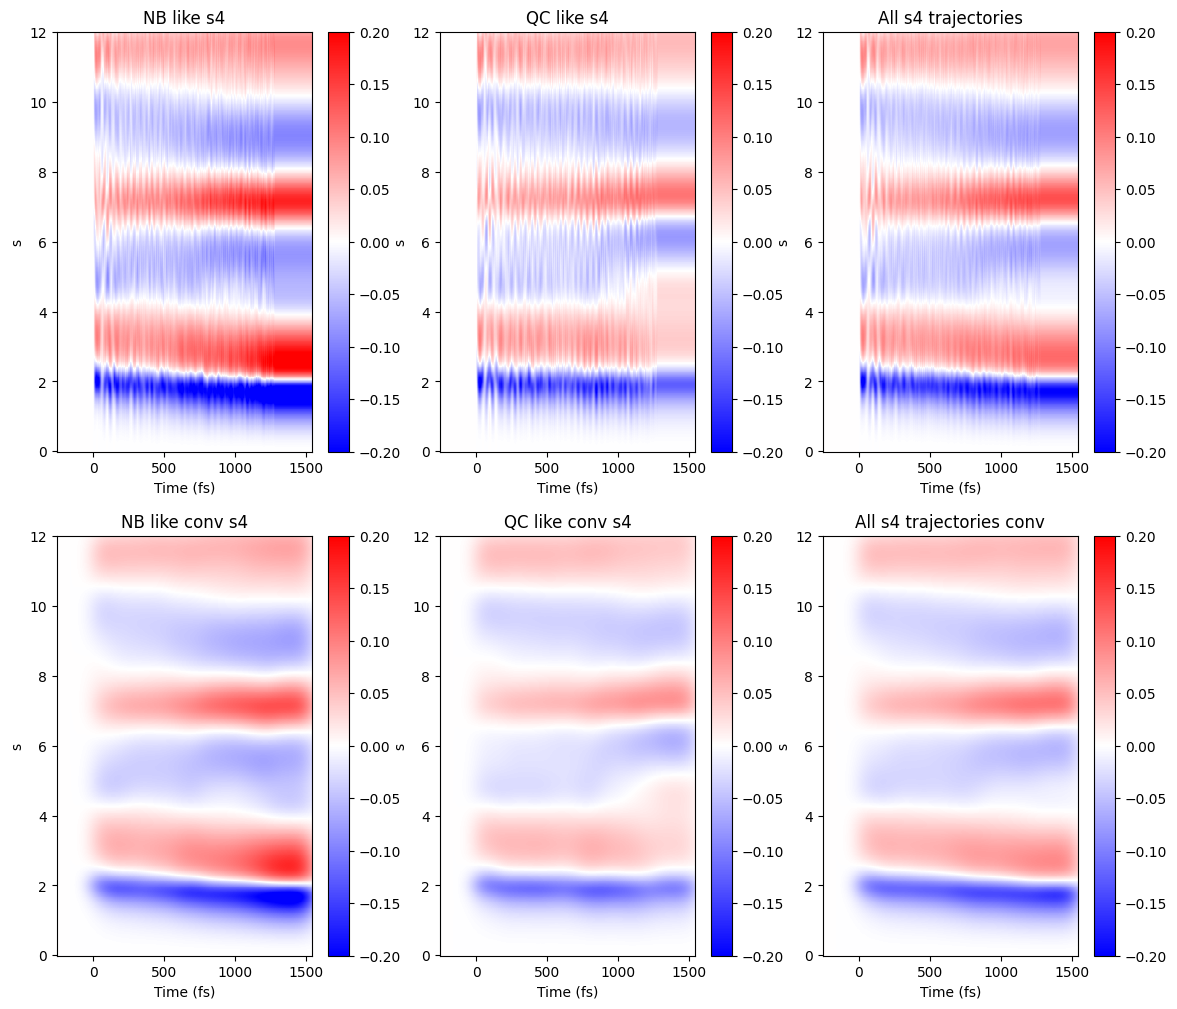

In [37]:
plt.figure(figsize=(14,12))
plt.subplot(2,3,1)
plt.pcolor(time_vals, NB_s2_traj["0107"]["s"], NB_s4_dI, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("NB like s4")

plt.subplot(2,3,2)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], QC_s4_dI, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("QC like s4")

s4_all = np.mean((NB_s4_dI, QC_s4_dI), axis=0)
print(s4_all.shape)
plt.subplot(2,3,3)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], s4_all, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title("All s4 trajectories")
plt.colorbar()

plt.subplot(2,3,4)
plt.pcolor(time_vals, NB_s2_traj["0107"]["s"], NB_s4_dI_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("NB like conv s4")

plt.subplot(2,3,5)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], QC_s4_dI_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("QC like conv s4")

s4_all_conv = np.mean((NB_s4_dI_conv, QC_s4_dI_conv), axis=0)
print(s4_all.shape)
plt.subplot(2,3,6)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], s4_all_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title("All s4 trajectories conv")
plt.colorbar()
plt.show()

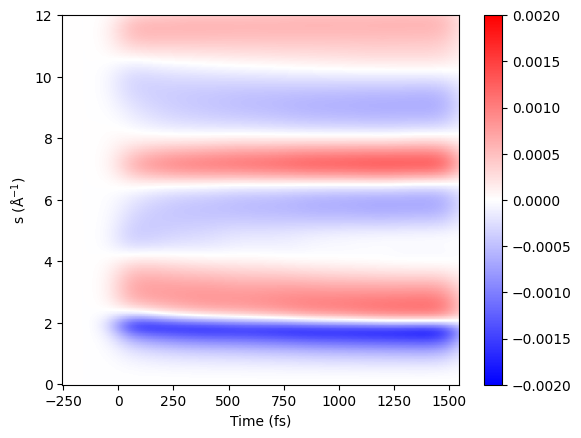

In [38]:
plt.figure()
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], dI_I_all_traj_conv/100, cmap='bwr')
plt.clim(-0.002, 0.002)
plt.xlabel("Time (fs)")
plt.ylabel("s ($\mathrm{\AA}^{-1}$)")
# plt.title("All Trajectories conv")
plt.colorbar()
plt.show()

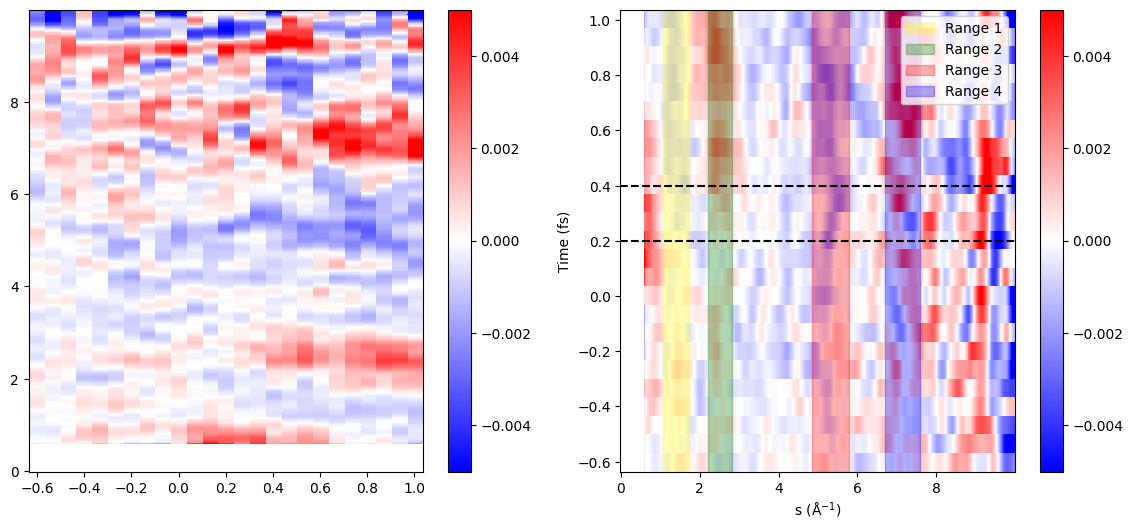

In [39]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.pcolor(time_exp, s_simu, dI_I_smooth, cmap='bwr')
plt.clim(-0.005,0.005)
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(s_simu, time_exp, dI_I_smooth.T, cmap='bwr')
plt.clim(-0.005, 0.005)
plt.xlabel(f"s {inv_angs}")
plt.colorbar()
plt.ylabel("Time (fs)")

# Overlay the shaded regions for each range
plt.axvspan(min_s1, max_s1, color='yellow', alpha=0.3, label='Range 1')  # shade range 1
plt.axvspan(min_s2, max_s2, color='green', alpha=0.3, label='Range 2')  # shade range 2
plt.axvspan(min_s3, max_s3, color='red', alpha=0.3, label='Range 3')    # shade range 3
plt.axvspan(min_s4, max_s4, color='blue', alpha=0.3, label='Range 4')   # shade range 4
plt.axhline(y=0.2, color='k', linestyle='--')
plt.axhline(y=0.4, color='k',  linestyle='--')

# Add a legend
plt.legend(loc='upper right')

plt.show()

## Plot Time Lineouts

In [99]:
def normalize(data_set, max_val='Auto', min_val='Auto'):
    if max_val == 'Auto':
        normalized_data = (data_set - np.nanmin(data_set))/(np.nanmax(data_set) - np.nanmin(data_set))
        std_factor = 1/(np.nanmax(data_set) - np.nanmin(data_set))
    elif isinstance(max_val, float) and isinstance(min_val, float):
        normalized_data = (data_set - min_val)/(max_val - min_val)
        std_factor = 1/(max_val-min_val)
    return normalized_data, std_factor

In [102]:
#print(dI_I_boot.shape)
dI_I_ave = np.nanmean(dI_I_boot, axis=2).T
#print(dI_I_ave)
dI_I_feat1 = np.nansum(np.abs(dI_I_boot[exp_indices][:]), axis=0)
print(dI_I_feat1.shape)
dI_I_feat1_mean = np.nanmean(dI_I_feat1[:-4], axis=1)
dI_I_feat1_mean.shape
dI_I_feat1_err = np.nanstd(dI_I_feat1[:-4], axis=1)
#print(dI_I_feat1_err)

min_val = np.nanmean(dI_I_feat1_mean[np.where((time_exp > -0.3) & (time_exp < 0.0))[0]])
max_val = np.nanmean(dI_I_feat1_mean[np.where((time_exp > 0.8) & (time_exp < 1.00))[0]])

print(min_val, max_val)
dI_I_feat1_norm, std_factor = normalize(dI_I_feat1_mean, max_val=max_val, min_val=min_val)
dI_I_feat1_err = dI_I_feat1_err*std_factor
print(dI_I_feat1_norm)
# dI_I_feat1_mean = np.nanmean(dI_I_feat1_norm, axis=1)
# dI_I_feat1_err = np.nanstd(dI_I_feat1_norm, axis=1)
# print(dI_I_feat1_norm)
# print(dI_I_feat1_err.shape)

# # dI_I_electronic = np.nanmean(normalize(np.nansum(np.abs(dI_I_boot[np.where(s_simu < 1.8)[0]]), axis=0), axis=1))
# # dI_I_electronic_err = np.nanstd(normalize(np.nansum(np.abs(dI_I_boot[np.where(s_simu < 1.8)[0]]), axis=0)), axis=1)
# # print(dI_I_electronic.shape)
time_new = time_exp[:-4]
print(time_new.shape)

(25, 100)
0.12533603428933504 0.2702857546322086
[ 1.14996881  0.83221273  1.02949078  1.13829649  1.29769194  0.87087596
  0.71960064  0.58802333  0.39429821  0.48239147  0.40348073  0.05930235
  0.00923556  0.15432945 -0.06908278  0.0578189  -0.03171226 -0.04509455
  0.01985087  0.05695594 -0.14822169]
(21,)


In [105]:
NB_s2_min = np.nanmean(NB_s2_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s2_max = np.nanmean(NB_s2_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000)[0])])
NB_s2_feat1_norm, _ = normalize(NB_s2_feat_1_conv, max_val=NB_s2_max, min_val=NB_s2_min)
print(NB_s2_feat1_norm.shape)
QC_s2_min = np.nanmean(QC_s2_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s2_max = np.nanmean(QC_s2_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000)[0])])
QC_s2_feat1_norm, _ = normalize(QC_s2_feat_1_conv, max_val=QC_s2_max, min_val=QC_s2_min)
print(QC_s2_feat1_norm.shape)

NB_s3_min = np.nanmean(NB_s3_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s3_max = np.nanmean(NB_s3_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000)[0])])
NB_s3_feat1_norm, _ = normalize(NB_s3_feat_1_conv, max_val=NB_s3_max, min_val=NB_s3_min)
print(NB_s3_feat1_norm.shape)

QC_s3_min = np.nanmean(QC_s3_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s3_max = np.nanmean(QC_s3_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000)[0])])
QC_s3_feat1_norm, _ = normalize(QC_s3_feat_1_conv, max_val=QC_s3_max, min_val=QC_s3_min)

NB_s4_min = np.nanmean(NB_s4_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s4_max = np.nanmean(NB_s4_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000)[0])])
NB_s4_feat1_norm, _ = normalize(NB_s4_feat_1_conv, max_val=NB_s4_max, min_val=NB_s4_min)
print(NB_s4_feat1_norm.shape)

QC_s4_min = np.nanmean(QC_s4_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s4_max = np.nanmean(QC_s4_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000)[0])])
QC_s4_feat1_norm, _ = normalize(QC_s4_feat_1_conv, max_val=QC_s4_max, min_val=QC_s4_min)


(2800,)
(2800,)
(2800,)
(2800,)


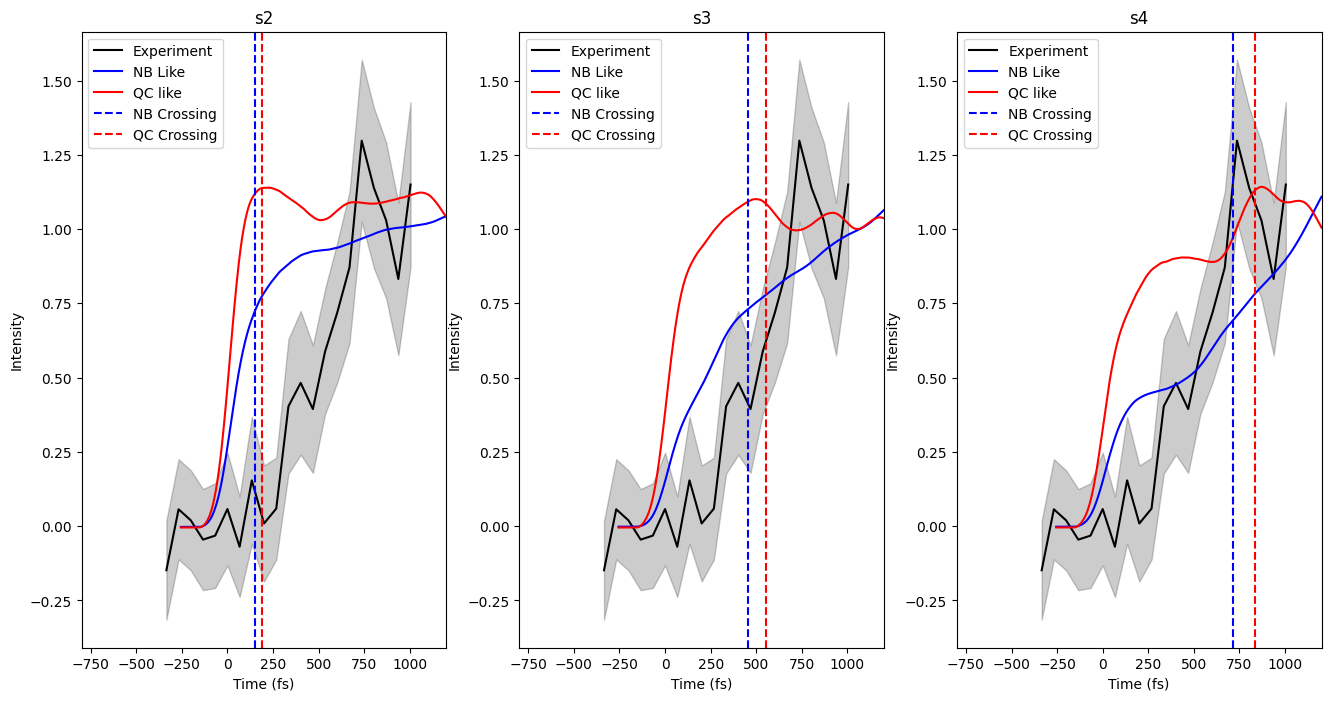

In [110]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err, dI_I_feat1_norm+dI_I_feat1_err, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*100, yerr=dI_I_electronic_err*100, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s2_feat1_norm,  color="blue", label="NB Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s2_feat1_norm, color="red", label="QC like")
#plt.plot(time_vals, QC_s2_feat_1_conv, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s2_CI, color="blue", label="NB Crossing", linestyle="--")
plt.axvline(x=QC_s2_CI, color="red", label="QC Crossing", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s2")
plt.xlim(-800, 1200)
plt.legend()

plt.subplot(1,3,2)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err, dI_I_feat1_norm+dI_I_feat1_err, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*50, yerr=dI_I_electronic_err*50, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s3_feat1_norm,  color="blue", label="NB Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s3_feat1_norm, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s3_CI, color="blue", label="NB Crossing", linestyle="--")
plt.axvline(x=QC_s3_CI, color="red", label="QC Crossing", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s3")
plt.xlim(-800, 1200)
plt.legend()

plt.subplot(1,3,3)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err, dI_I_feat1_norm+dI_I_feat1_err, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*50, yerr=dI_I_electronic_err*50, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s4_feat1_norm,  color="blue", label="NB Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s4_feat1_norm, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s4_CI, color="blue", label="NB Crossing", linestyle="--")
plt.axvline(x=QC_s4_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s4")
plt.xlim(-800, 1200)
plt.legend()

plt.show()

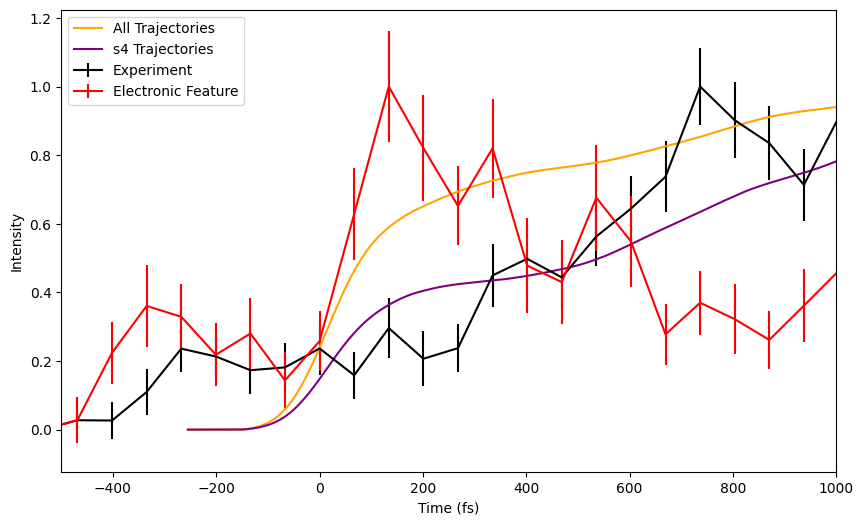

In [17]:
plt.figure(figsize=(10,6))
plt.errorbar(time_exp*1000, dI_I_feat1_mean, yerr=dI_I_feat1_err, color="k", label="Experiment")
plt.errorbar(time_exp*1000, dI_I_electronic, yerr=dI_I_electronic_err, color="red", label="Electronic Feature")
plt.plot(time_vals, normalize(dI_I_all_traj_feat1_conv), color="orange", label="All Trajectories")
plt.plot(time_vals, normalize(dI_I_s4_feat1_conv), color="purple", label="s4 Trajectories")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.legend()
plt.xlim(-500, 1000)
plt.show()

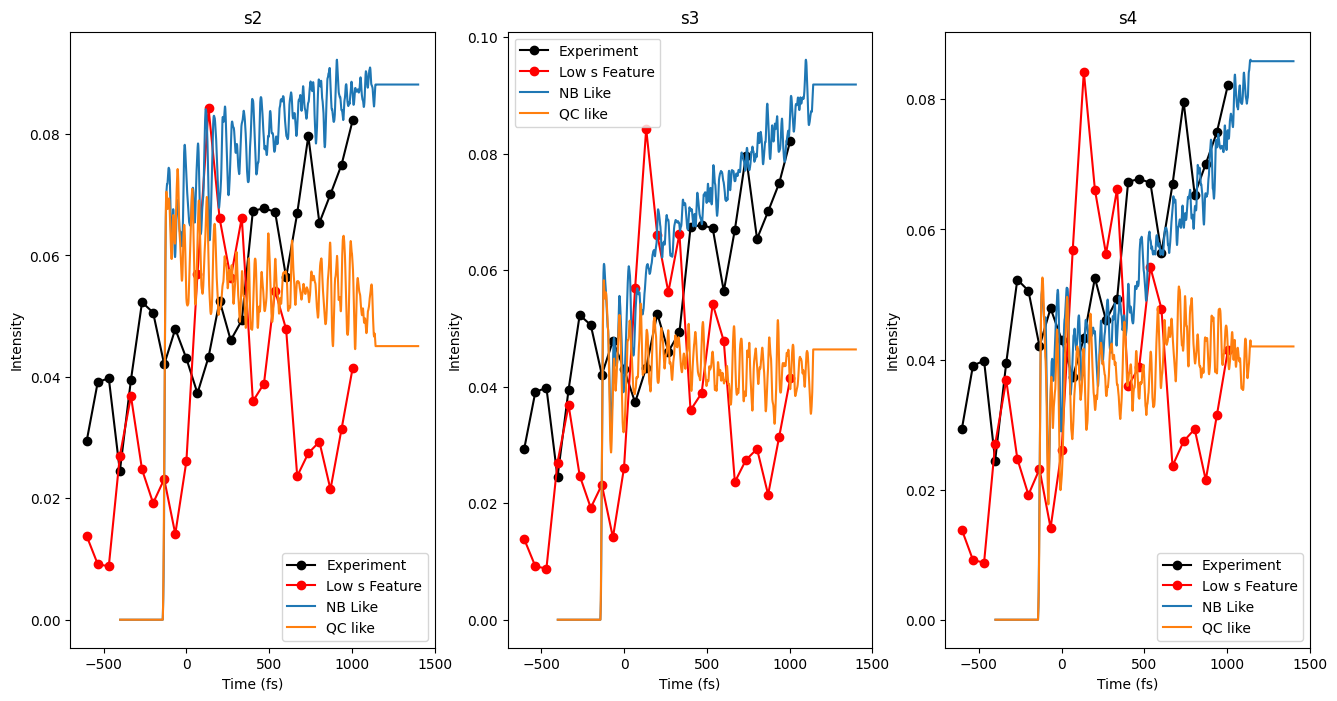

In [51]:

# print(dI_I_feat1.shape)
time_vals = NB_s2_traj["0008"]["time"] + 150
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.plot(time_exp*1000, dI_I_mean*50, "-o", color="k", label="Experiment")
#plt.plot(time_exp*1000, dI_I_electronic*50, "-o", color='r', label="Low s Feature")
plt.plot(time_vals, NB_s2_mean, label="NB Like")
plt.plot(time_vals, QC_s2_mean, label="QC like")
#plt.plot(time_vals, (NB_s2_feat_1 + QC_s2_feat_1), label="Sum")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s2")
plt.legend()

plt.subplot(1,3,2)
plt.plot(time_exp*1000, dI_I_mean*50, "-o", color="k", label="Experiment")
#plt.plot(time_exp*1000, dI_I_electronic*50, "-o", color='r', label="Low s Feature")
plt.plot(time_vals, NB_s3_mean, label="NB Like")
plt.plot(time_vals, QC_s3_mean, label="QC like")
#plt.plot(time_vals, (NB_s3_feat_1 + QC_s3_feat_1), label="Sum")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s3")
plt.legend()

plt.subplot(1,3,3)
plt.plot(time_exp*1000, dI_I_mean*50, "-o", color="k", label="Experiment")
#plt.plot(time_exp*1000, dI_I_electronic*50, "-o", color='r', label="Low s Feature")
plt.plot(time_vals, NB_s4_mean, label="NB Like")
plt.plot(time_vals, QC_s4_mean, label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s4")
plt.legend()

plt.show()

## Look at only slow data

In [106]:
NB_slow_ids = []
NB_slow_CIs = []
NB_slow_dIs = []
NB_slow_groups =[]

QC_slow_ids = []
QC_slow_CIs = []
QC_slow_dIs = []
QC_slow_groups =[]

In [109]:
print(len(NB_slow_CIs))
print(len(QC_slow_CIs))

23
16


In [108]:
for key in NB_s4_traj.keys():
    if NB_s4_traj[key]["CI_time"] > 300:
        dI_I = NB_s4_traj[key]["dI_I_raw"].T
        NB_slow_ids.append(key)
        NB_slow_dIs.append(dI_I)
        NB_slow_CIs.append(NB_s4_traj[key]["CI_time"])
        NB_slow_groups.append("s4")

for key in QC_s4_traj.keys():
    if QC_s4_traj[key]["CI_time"] > 300:
        dI_I = QC_s4_traj[key]["dI_I_raw"].T
        QC_slow_ids.append(key)
        QC_slow_dIs.append(dI_I)
        QC_slow_CIs.append(QC_s4_traj[key]["CI_time"])
        QC_slow_groups.append("s4")    


KeyError: 'CI_time'

(2800,)
(2800,)


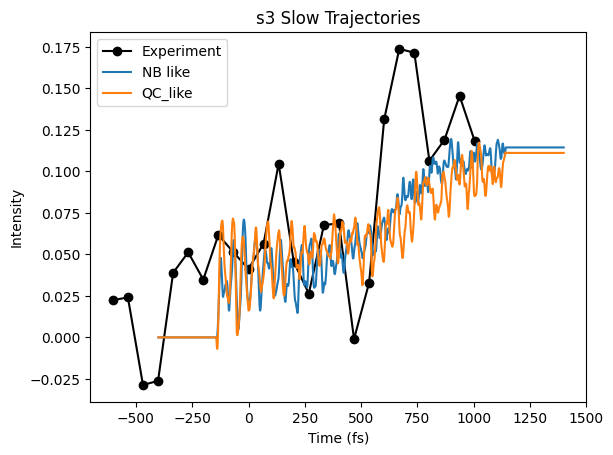

In [110]:
QC_slow_dI_mean = np.mean(np.array(QC_slow_dIs), axis=0)
NB_slow_dI_mean = np.mean(np.array(NB_slow_dIs), axis=0)

NB_slow_feat1 = np.mean(NB_slow_dI_mean[np.where((s_simu> 7) & (s_simu < 8))[0]], axis=0)
QC_slow_feat1 = np.mean(QC_slow_dI_mean[np.where((s_simu >7) & (s_simu < 8))[0]], axis=0)
print(NB_slow_feat1.shape)
print(QC_slow_feat1.shape)

plt.figure()
plt.plot(time_exp*1000, dI_I_feat1*50, "-o", color='k', label="Experiment")
plt.plot(time_vals, NB_slow_feat1, label="NB like")
plt.plot(time_vals, QC_slow_feat1, label="QC_like")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title("s3 Slow Trajectories")
plt.legend()
plt.show()


## Fit all data and save fit_line to h5 file and fit details to a log file

In [21]:
# Define the error function using scipy.special.erf
# def error_function(t, a, t0, sigma, offset):
#     return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset

# # Define bounds for the parameters [amplitude, t0, sigma, offset]
# bounds = ([-1, -0.5, 0, -0.1], [1, 1, 1.5, 0.1])  # lower bounds, upper bounds
# guesses = [0.01, 0.5, 0.5, 0.0]

# # Open a text file to log the results

# log_file = f'{group_name}_fit_results.txt'  # Text file to store fit results
# with open(log_file, 'a') as log:
    
#     # Write the header row only if the file is empty
#     if log.tell() == 0:
#         log.write("Run_Number\tt_0\t\tt_error\tsigma\tsigma_error\toffset\n")

#     # Open the HDF5 file for saving fit_line data
#     with h5py.File(file_name, 'a') as f:
        
#         for key in s2_trajectories.keys():
#             data = s2_trajectories[key]["dI_I_conv"].T
#             time_vals = s2_trajectories[key]["time"]
#             mean_data = np.mean(np.abs(data), axis=0)  # average the absolute value of all the data across s range
            
#             # Fit absolute value of all data
#             popt, pcov = scipy.optimize.curve_fit(error_function, time_vals, mean_data, p0=guesses, bounds=bounds)
#             A, t0, sigma, offset = popt
#             t0_error = np.sqrt(pcov[1, 1])
#             sigma_error = np.sqrt(pcov[2, 2])
            
#             # Write the fitting results to the text file in tab-separated format
#             log.write(f"{key}\t{t0:.4f}\t{t0_error:.3f}\t{sigma:.4f}\t{sigma_error:.3f}\t{offset:.4f}\n")
#             print(f"{key}\t{t0:.4f}\t{t0_error:.3f}\t{sigma:.4f}\t{sigma_error:.3f}\t{offset:.4f}\n")
#             print(f"Run {key} results written to file.")
            
#             # Generate the fit line
#             fit_line = error_function(time_vals, A, t0, sigma, offset)
            
#             # Navigate to the group in the HDF5 file (create if not exists)
#             if group_name not in f:
#                 group = f.create_group(group_name)
#             else:
#                 group = f[group_name]
            
#             # Check if the dataset already exists and overwrite it
#             dataset_name = f"fit_line_run_{key}"
#             if dataset_name in group:
#                 print(f"Overwriting dataset '{dataset_name}'")
#                 del group[dataset_name]
            
#             # Create the dataset for the fit_line
#             group.create_dataset(dataset_name, data=fit_line)
#             print(f"Fit line for run {key} saved successfully.")



0014	-0.5000	1.979	1.5000	6.589	0.1000

Run 0014 results written to file.
Fit line for run 0014 saved successfully.
0050	-0.5000	1.833	1.5000	6.102	0.1000

Run 0050 results written to file.
Fit line for run 0050 saved successfully.
0054	-0.1445	0.000	0.0103	0.000	0.1000

Run 0054 results written to file.
Fit line for run 0054 saved successfully.
0066	-0.5000	1.330	1.5000	4.427	0.1000

Run 0066 results written to file.
Fit line for run 0066 saved successfully.
0091	-0.5000	3.543	1.5000	11.799	0.1000

Run 0091 results written to file.
Fit line for run 0091 saved successfully.
0111	-0.5000	1.526	1.5000	5.080	0.1000

Run 0111 results written to file.
Fit line for run 0111 saved successfully.
0113	-0.5000	1.958	1.5000	6.519	0.1000

Run 0113 results written to file.
Fit line for run 0113 saved successfully.
0152	-0.5000	1.895	1.5000	6.309	0.1000

Run 0152 results written to file.
Fit line for run 0152 saved successfully.
0229	-0.5000	2.528	1.5000	8.417	0.1000

Run 0229 results written to fil

## Get Product Ratios

In [102]:
import numpy as np
from pyswarm import pso  # Particle Swarm Optimization
import random

def three_param_fit(data, err, dI_I_fit1, dI_I_fit2, dI_I_fit3, nSwarm=2000, s_start=50, s_end=370):
    random.seed()  # Equivalent to rng('shuffle')

    # Lower and upper bounds
    lb = [0.0001, 0, 0, -200]
    ub = [100, 100, 200, 500]

    s = np.arange(0, len(data)) * 0.025  # creating s range

    # Particle Swarm Optimization
    def findCorrPar(c):
        total_perc = c[0] + c[1] + c[2]
        dI_I_end = (1 / total_perc) * (c[0] * dI_I_fit1 + c[1] * dI_I_fit2 + c[2] * dI_I_fit3)

        # Chi-squared like calculation (objective function)
        obj = (1 / (s_end - s_start) - len(lb)) * np.nansum(
            ((data[s_start:s_end] - (1 / c[3]) * dI_I_end[s_start:s_end]) / err[s_start:s_end]) ** 2
        )
        
        # Penalty to ensure that total percentage sums to 100
        penalty = 1e6 * (total_perc - 100) ** 2
        
        return obj + penalty  # Add penalty to objective function

    # Perform the PSO optimization
    coeffs, fopt = pso(findCorrPar, lb, ub, swarmsize=nSwarm, maxiter=nSwarm * 2, 
                       minstep=1e-4, debug=True)

    # Extract coefficients
    c = coeffs
    total_final = c[0] + c[1] + c[2]
    
    # Calculate dI_I_end and percentages
    dI_I_end = (1 / total_final) * (c[0] * dI_I_fit1 + c[1] * dI_I_fit2 + c[2] * dI_I_fit3)
    perc1 = (c[0] / total_final) * 100
    perc2 = (c[1] / total_final) * 100
    perc3 = (c[2] / total_final) * 100

    # Chi-squared calculation
    chi = (1 / (s_end - s_start) - len(lb)) * np.nansum(
        ((data[s_start:s_end] - (1 / c[3]) * dI_I_end[s_start:s_end]) / err[s_start:s_end]) ** 2
    )
    
    print(chi)

    return coeffs, perc1, perc2, perc3, dI_I_end, chi




In [59]:
late_dI = np.nanmean(dI_I_smooth[:, np.where((time_exp<0.7)&(time_exp<1))[0]], axis=1)
late_dI_std = np.nanstd(dI_I_smooth[:][:-4], axis=1)

#coeffs, perc_NB, perc_QC, perc_frags, dI_I_fit, chi = three_param_fit(late_dI, late_dI_std, (NBD_simu/100), (QC_simu/100), (frag_simu/100))

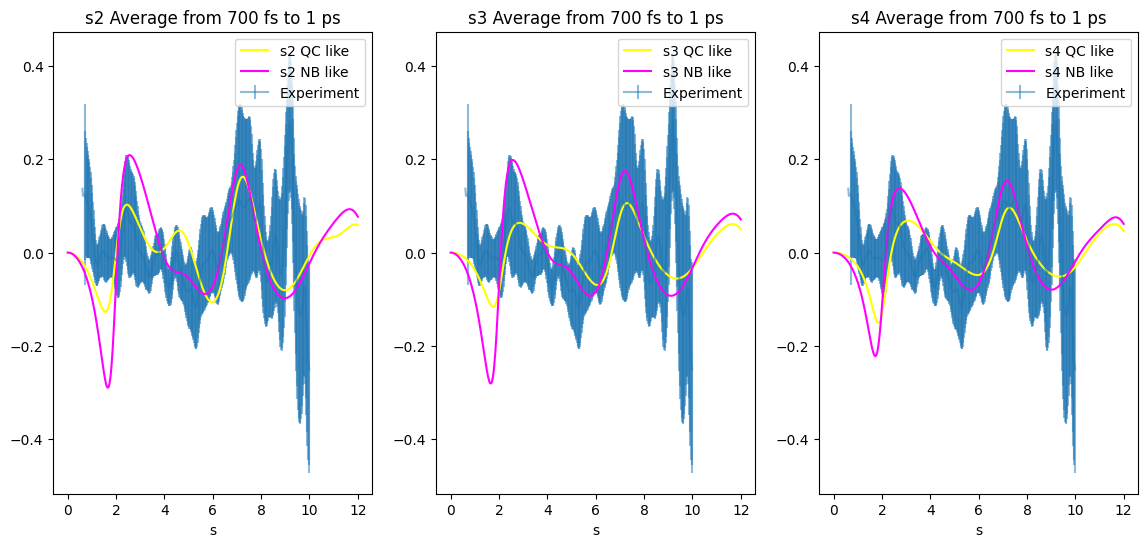

In [69]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.errorbar(s_simu[4:], late_dI[4:]*100, yerr=late_dI_std*100, alpha=0.5, label="Experiment")
plt.plot(QC_s2_traj["0014"]["s"], QC_s2_late, color="yellow", label="s2 QC like")
plt.plot(NB_s2_traj["0020"]["s"], NB_s2_late, color="magenta", label="s2 NB like")
plt.xlabel("s")
plt.title("s2 Average from 700 fs to 1 ps")
plt.legend()

plt.subplot(1,3,2)
plt.errorbar(s_simu[4:], late_dI[4:]*100, yerr=late_dI_std*100, alpha=0.5, label="Experiment")
plt.plot(QC_s2_traj["0014"]["s"], QC_s3_late, color="yellow", label="s3 QC like")
plt.plot(NB_s2_traj["0020"]["s"], NB_s3_late, color="magenta", label="s3 NB like")
plt.xlabel("s")
plt.title("s3 Average from 700 fs to 1 ps")
plt.legend()

plt.subplot(1,3,3)
plt.errorbar(s_simu[4:], late_dI[4:]*100, yerr=late_dI_std*100, alpha=0.5, label="Experiment")
plt.plot(QC_s2_traj["0014"]["s"], QC_s4_late, color="yellow", label="s4 QC like")
plt.plot(NB_s2_traj["0020"]["s"], NB_s4_late, color="magenta", label="s4 NB like")
plt.xlabel("s")
plt.title("s4 Average from 700 fs to 1 ps")
plt.legend()

plt.show()

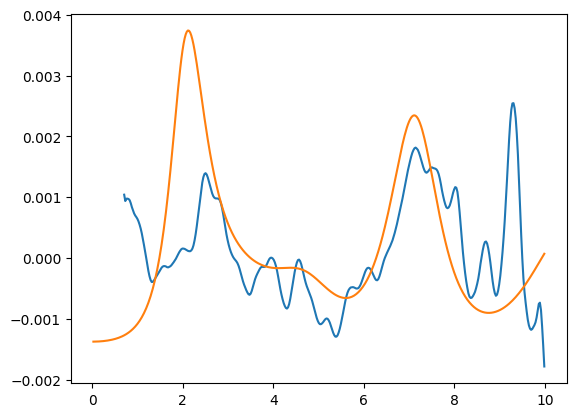

In [100]:

plt.figure()
plt.plot(s_simu[4:], late_dI)
plt.plot(s_simu, dI_I_fit)
plt.show()